In [1]:
import pandas as pd
import numpy as np
import geojson

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from ast import literal_eval
import collections

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

In [2]:
### raw, original files with all datapoints
listings_link = 'data/listings.csv.gz'
reviews_link = 'data/reviews.csv.gz'
calendar_link = 'data/calendar.csv.gz'

### shortened summary of listings: just a few main features from the original file
listings_sum_link = 'data/listings.csv'

### neighborhood information
neighborhoods_link = 'data/neighbourhoods.csv'
neighborhoods_gjson_link = 'data/neighbourhoods.geojson'

In [3]:
### read 'big' gzipped files
listings = pd.read_csv(listings_link, compression = 'gzip', error_bad_lines = False)
reviews = pd.read_csv(reviews_link, compression = 'gzip', error_bad_lines = False)
calendar = pd.read_csv(calendar_link, compression = 'gzip', error_bad_lines = False)

### read neighborhhood info
neighborhoods = pd.read_csv(neighborhoods_link)

### read summarized data of listings
listings_summarized = pd.read_csv(listings_sum_link)

### read geojson with neighborhood geo data
with open(neighborhoods_gjson_link) as f:
    neighborhoods_gjson = geojson.load(f)

### Check files

Listings summarized is just a few of the original features, plus the grouped neighborhood. I'll go over all features and select the necessary ones and do feature engineering manually

In [4]:
listings.head(2)

id                        listing_url       scrape_id last_scraped  \
0  6623  https://www.airbnb.com/rooms/6623  20210806113017   2021-08-06   
1  6624  https://www.airbnb.com/rooms/6624  20210806113017   2021-08-06   

                                   name  \
0        Venice Blue on Canal apartment   
1  Venice garden charme and canal view!   

                                         description  \
0  I'm thrilled to share my "Blue on Venice Canal...   
1  I'm thrilled to share my apartment with garden...   

                               neighborhood_overview  \
0  Close by is the Frari Church (known as Tiziano...   
1  We are in the middle of a residential area cal...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/492258/834683...    15016   
1  https://a0.muscache.com/pictures/65440024/a564...    15016   

                                  host_url  ... review_scores_communication  \
0  https://www.airbnb.com/users/show/15016  ...                        4.85   
1  https://www.airbnb.com/users/show/15016  ...                        4.85   

  review_scores_location review_scores_value license instant_bookable  \
0                   4.96                4.92     NaN                f   
1                   4.93                4.92     NaN                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              3                                           3   
1                              3                                           3   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              1.55  
1                                           0              0.68  

[2 rows x 74 columns]

In [5]:
listings_summarized.head(2)

id                                  name  host_id  host_name  \
0  6623        Venice Blue on Canal apartment    15016  Francesca   
1  6624  Venice garden charme and canal view!    15016  Francesca   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0               Isole      San Polo  45.43823   12.32902  Entire home/apt   
1               Isole   Santa Croce  45.43971   12.32799  Entire home/apt   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    225               7                162  2019-06-26               1.55   
1    250               7                 64  2016-07-17               0.68   

   calculated_host_listings_count  availability_365  
0                               3               351  
1                               3               338

On the reviews some text mining can be done after the usual cleaning:
- word count
- tf idf vectorization
- count vectorization
- sentiment scoring

In [6]:
reviews.head(2)

listing_id     id        date  reviewer_id reviewer_name  \
0        6623  17303  2009-11-15        44144      Adrienne   
1        6623  33380  2010-04-04        99704       Yannick   

                                            comments  
0  The Blue on Venice Canal apartment was beyond ...  
1  We stayed in Blue on Venice Canal over Easter ...

Calendar includes daily prices for up to a year. Monthly aggregation, or just simple overall median can be taken..

In [7]:
calendar.head(2)

listing_id        date available    price adjusted_price  minimum_nights  \
0      567154  2021-08-06         f   $95.00         $95.00             4.0   
1      275264  2021-08-06         f  $137.00        $137.00             2.0   

   maximum_nights  
0          1125.0  
1          1125.0

Neighborhood groups will be used to reduce cardinality of neighborhood feature

In [8]:
neighborhoods.head(2)

neighbourhood_group neighbourhood
0               Isole      Alberoni
1               Isole        Burano

## 1 Clean the calendar

In [9]:
calendar.head(2)

listing_id        date available    price adjusted_price  minimum_nights  \
0      567154  2021-08-06         f   $95.00         $95.00             4.0   
1      275264  2021-08-06         f  $137.00        $137.00             2.0   

   maximum_nights  
0          1125.0  
1          1125.0

In [10]:
calendar['price'] = calendar['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
calendar['adjusted_price'] = calendar['adjusted_price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

calendar = calendar[calendar['price'] != 0] # no price means no target value
calendar.drop('adjusted_price', 1, inplace = True) # dont want to incorporate promotions, etc...

#### Aggregating listing prices monthly

In [11]:
calendar['year'] = pd.to_datetime(calendar['date']).dt.year
calendar['month'] = pd.to_datetime(calendar['date']).dt.month

In [12]:
calendar.head(2)

listing_id        date available  price  minimum_nights  maximum_nights  \
0      567154  2021-08-06         f   95.0             4.0          1125.0   
1      275264  2021-08-06         f  137.0             2.0          1125.0   

   year  month  
0  2021      8  
1  2021      8

In [13]:
price_calendar = calendar.groupby(['listing_id', 'year', 'month']).agg({'price' : 'median', 'minimum_nights' : 'median', 'maximum_nights' : 'median'}).reset_index()
price_calendar.head(3)

listing_id  year  month  price  minimum_nights  maximum_nights
0        6623  2021      8  225.0             7.0           365.0
1        6623  2021      9  225.0             7.0           365.0
2        6623  2021     10  225.0             7.0           365.0

The calendar may not be used afterall, the listings file has a price point for the day of scraping. That price is going to be predicted with the available, respective-in-time features

## 2 Clean listings

In [14]:
to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'picture_url', 
           'host_url', 'host_id', 'host_name', 'host_thumbnail_url', 'host_picture_url',
           'calendar_last_scraped', 'host_location', 'host_verifications', 'property_type']
listings.drop(to_drop, 1, inplace = True)

#### Check missing ratios

In [15]:
(listings.isnull().sum() / listings.shape[0])[(listings.isnull().sum() / listings.shape[0]) > 1/3]

neighborhood_overview    0.355480
host_about               0.445325
host_neighbourhood       0.390588
neighbourhood            0.355480
bathrooms                1.000000
calendar_updated         1.000000
license                  0.864980
dtype: float64

In [16]:
to_drop = (listings.isnull().sum() / listings.shape[0])[(listings.isnull().sum() / listings.shape[0]) > 1/3].index

Create features indicating missing or filled info:
- host has description
- neighborhood has description

Delete remaining features with many NaNs

In [17]:
listings['description_host'] = listings['host_about'].apply(lambda x: 1 if x is np.nan else 0)
listings['description_neighbourhood'] = listings['neighborhood_overview'].apply(lambda x: 1 if x is np.nan else 0)

listings.drop(to_drop, 1, inplace = True)

#### Check True/False features

In [18]:
true_false_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                      'has_availability', 'instant_bookable']

In [19]:
listings[true_false_columns].isnull().sum()

host_is_superhost         230
host_has_profile_pic      230
host_identity_verified    230
has_availability            0
instant_bookable            0
dtype: int64

In [20]:
listings = listings[listings['host_is_superhost'].notnull()]

In [21]:
for col in true_false_columns:
    listings[col] = listings[col].apply(lambda x: 1 if x == 't' else 0)

#### Check categorical features

In [22]:
listings.describe(include = 'O').T

count unique  \
name                          7717   7557   
description                   7581   7230   
host_since                    7717   2201   
host_response_time            6226      4   
host_response_rate            6226     49   
host_acceptance_rate          6196     72   
neighbourhood_cleansed        7717     57   
neighbourhood_group_cleansed  7717      2   
room_type                     7717      4   
bathrooms_text                7701     29   
amenities                     7717   7052   
price                         7717    474   
first_review                  6410   2083   
last_review                   6410   1186   

                                                                            top  \
name                                                            Villa Annamaria   
description                   Room with standard double bed, wardrobe and eq...   
host_since                                                           2012-06-14   
host_response_time                                               within an hour   
host_response_rate                                                         100%   
host_acceptance_rate                                                       100%   
neighbourhood_cleansed                                               Cannaregio   
neighbourhood_group_cleansed                                              Isole   
room_type                                                       Entire home/apt   
bathrooms_text                                                           1 bath   
amenities                     ["Heating", "Wifi", "Oven", "Private entrance"...   
price                                                                   $100.00   
first_review                                                         2021-07-18   
last_review                                                          2021-07-23   

                              freq  
name                             6  
description                     17  
host_since                     136  
host_response_time            5055  
host_response_rate            4530  
host_acceptance_rate          3755  
neighbourhood_cleansed        1503  
neighbourhood_group_cleansed  6374  
room_type                     5820  
bathrooms_text                4279  
amenities                       17  
price                          248  
first_review                    27  
last_review                     66

The following features need to be converted to floats:

- host since (years ago)
- host response rate (0-1 float)
- host acceptance rate (0-1 float)
- bathrooms (count)
- price
- first review (years ago)
- last review (years ago)

The following features will need to be 'exploded' / 'one-hot-encoded':
- amenities (for all amenities a has_amenity true/false feature will be created

The following features will be grouped to reduce cardinality:
- property type
- neighborhoods

Neighbourhoods

In [23]:
top_neighborhoods = listings['neighbourhood_cleansed'].value_counts().head(8).index.tolist()

listings['neighbourhood_cleansed_grouped'] = listings['neighbourhood_cleansed'].apply(lambda x: x if x in top_neighborhoods else 'Other')

In [24]:
listings.loc[(listings['neighbourhood_cleansed_grouped'] == 'Other') &
             (listings['neighbourhood_group_cleansed'] == 'Isole'), 'neighbourhood_cleansed_grouped'] = 'Other on Isole'

listings.loc[(listings['neighbourhood_cleansed_grouped'] == 'Other') &
             (listings['neighbourhood_group_cleansed'] == 'Terraferma'), 'neighbourhood_cleansed_grouped'] = 'Other on Terraferma'

Everything else

In [25]:
today_date = pd.to_datetime('2021-08-30')

listings['host_since_years'] = (today_date - pd.to_datetime(listings['host_since'])).dt.days / 365
listings['first_review_years'] = (today_date - pd.to_datetime(listings['first_review'])).dt.days / 365
listings['last_review_years'] = (today_date - pd.to_datetime(listings['last_review'])).dt.days / 365

listings['host_response_rate'] = listings['host_response_rate'].apply(lambda x: float(x.replace('%', '')) / 100 if type(x) == str else x)
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].apply(lambda x: float(x.replace('%', '')) / 100 if type(x) == str else x)
listings['price'] = listings['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

bath_replace = {'Shared half-bath' : '0.5 shared baths', 'Half-bath' : '0.5 baths'}
listings['bathrooms_text'] = listings['bathrooms_text'].replace(bath_replace)
listings['bathrooms_shared'] = listings['bathrooms_text'].apply(lambda x: 1 if 'shared' in str(x).lower() else 0)
listings['bathrooms_count'] = listings['bathrooms_text'].apply(lambda x: float(str(x).split(' ')[0]))

host_response_time_replace = {'within an hour' : 'within_hour', 'within a few hours' : 'within_few_hours', 'within a day' : 'within_day', 'a few days or more' : 'few_days'}
listings['host_response_time'] = listings['host_response_time'].replace(host_response_time_replace)

room_type_replace = {'Entire home/apt' : 'entire_place', 'Private room' : 'private_room', 'Hotel room' : 'hotel_room', 'Shared room' : 'shared_room'}
listings['room_type'] = listings['room_type'].replace(room_type_replace)

listings.drop(['host_since', 'first_review', 'last_review', 
               'bathrooms_text'], 1, inplace = True)

In [26]:
listings.describe(include = 'O').T

count unique  \
name                            7717   7557   
description                     7581   7230   
host_response_time              6226      4   
neighbourhood_cleansed          7717     57   
neighbourhood_group_cleansed    7717      2   
room_type                       7717      4   
amenities                       7717   7052   
neighbourhood_cleansed_grouped  7717     10   

                                                                              top  \
name                                                              Villa Annamaria   
description                     Room with standard double bed, wardrobe and eq...   
host_response_time                                                    within_hour   
neighbourhood_cleansed                                                 Cannaregio   
neighbourhood_group_cleansed                                                Isole   
room_type                                                            entire_place   
amenities                       ["Heating", "Wifi", "Oven", "Private entrance"...   
neighbourhood_cleansed_grouped                                         Cannaregio   

                                freq  
name                               6  
description                       17  
host_response_time              5055  
neighbourhood_cleansed          1503  
neighbourhood_group_cleansed    6374  
room_type                       5820  
amenities                         17  
neighbourhood_cleansed_grouped  1503

And now to treat the amenities

In [27]:
listings['amenities'] = listings['amenities'].apply(lambda x: literal_eval(x))

In [28]:
len(set().union(*listings['amenities']))

603

In [29]:
def consolidate_amenities_lists(amenities_list):
    
    consolidated_list = ['TV' if 'tv' in str(i).lower() else i for i in amenities_list]
    consolidated_list = ['Free parking' if ('free' in str(i).lower() and 'parking' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Free parking' if ('complimentary' in str(i).lower() and 'parking' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Free parking' if ('free' in str(i).lower() and 'garage' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Paid parking' if ('paid' in str(i).lower() and 'parking' in str(i).lower())else i for i in consolidated_list]
    consolidated_list = ['Air conditioning' if 'air conditioning' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Clothing storage' if 'clothing storage' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'refrigerator' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'fridge' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Washer' if 'washer' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Oven' if 'oven' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Soap' if 'soap' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Stove' if 'stove' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Shower' if 'shower' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Bath' if 'bath' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'cooler' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Shampoo' if 'shampoo' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Conditioner' if 'conditioner' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Sound system' if 'sound system' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Essentials' if 'essentials' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Children stuff' if 'children' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Workspace' if 'workspace' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Workspace' if 'office' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Dryer' if 'Dryer' in str(i) else i for i in consolidated_list]
    consolidated_list = ['Dryer' if ('free' in str(i).lower() and 'dryer' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Dryer' if ('paid' in str(i).lower() and 'dryer' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'wifi' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'ethernet' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'internet' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Heating' if 'heating' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Game console' if 'game console' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Gym' if 'gym' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Coffee maker' if 'coffee' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Coffee maker' if 'espresso' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Fireplace' if 'fireplace' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Fireplace' if 'fire pit' in str(i).lower() else i for i in consolidated_list]
        
    consolidated_list = list(collections.OrderedDict.fromkeys(consolidated_list))
    
    return consolidated_list

In [30]:
listings['amenities'] = listings['amenities'].apply(lambda x: consolidate_amenities_lists(x))

In [31]:
len(set().union(*listings['amenities']))

158

In [32]:
set().union(*listings['amenities'])

{'Air conditioning',
 'Airport shuttle',
 'BBQ grill',
 'Baby monitor',
 'Baby safety gates',
 'Babysitter recommendations',
 'Backyard',
 'Baking sheet',
 'Balcony',
 'Barbecue utensils',
 'Bath',
 'Beachfront',
 'Bed linens',
 'Bed sheets and pillows',
 'Bedroom comforts',
 'Bidet',
 'Board games',
 'Boat slip',
 'Bottled water',
 'Bread maker',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Building staff',
 'Carbon monoxide alarm',
 'Ceiling fan',
 'Changing table',
 'Children stuff',
 'Cleaning before checkout',
 'Cleaning products',
 'Clothing storage',
 'Coffee maker',
 'Complimentary breakfast',
 'Complimentary breakfast buffet',
 'Concierge',
 'Conditioner',
 'Cooking basics',
 'Courtyard',
 'Crib',
 'Desk',
 'Dining area',
 'Dining table',
 'Dishes and silverware',
 'Dryer',
 'Drying rack for clothing',
 'EV charger',
 'Elevator',
 'Essentials',
 'Extra pillows and blankets',
 'Fenced garden or backyard',
 'Fire extinguisher',
 'Fireplace',
 'First aid kit',
 'Formal d

After consolidation check top 15 amenities, keep them for one hot encoding

In [33]:
flattened_amenities = [item for sublist in listings['amenities'].tolist() for item in sublist]
amenities_count = collections.Counter(flattened_amenities)

amenities_count.most_common(15)

[('Heating', 7483),
 ('Wifi', 7333),
 ('Essentials', 7304),
 ('Hair dryer', 7202),
 ('Long term stays allowed', 6876),
 ('Hangers', 6541),
 ('Air conditioning', 6409),
 ('TV', 6396),
 ('Kitchen', 6271),
 ('Hot water', 5864),
 ('Shampoo', 5359),
 ('Iron', 5283),
 ('Washer', 5143),
 ('Refrigerator', 5026),
 ('Workspace', 5003)]

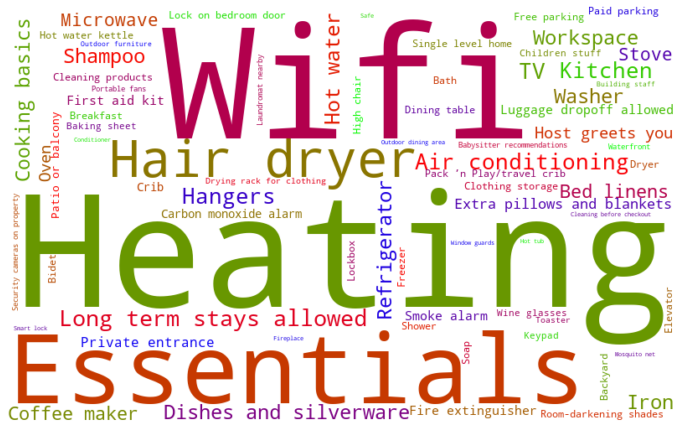

In [34]:
wordcloud = WordCloud(min_word_length = 3, background_color = 'white', width = 800, height = 500, 
                      max_words = 100, random_state = 20202020, min_font_size = 7, prefer_horizontal = 3/4,
                      colormap = 'brg')
wordcloud.generate_from_frequencies(amenities_count)

plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html

Other than the top 20 amenities, also keep the following:
- Pets allowed
- Self check-in

In [35]:
top_amenities = [i[0] for i in amenities_count.most_common(15)]
top_amenities.extend(['Pets allowed', 'Self check-in'])

print('Top amenities included: ', top_amenities)

Top amenities included:  ['Heating', 'Wifi', 'Essentials', 'Hair dryer', 'Long term stays allowed', 'Hangers', 'Air conditioning', 'TV', 'Kitchen', 'Hot water', 'Shampoo', 'Iron', 'Washer', 'Refrigerator', 'Workspace', 'Pets allowed', 'Self check-in']


In [36]:
def reduce_amenities(amenities_list):
    
    reduced_amenities = ['amenity_' + '_'.join(i.split()).lower() for i in amenities_list if i in top_amenities]
    
    return sorted(reduced_amenities)

In [37]:
listings['amenities'] = listings['amenities'].apply(lambda x: reduce_amenities(x))

In [38]:
for amenity_col in list(set().union(*listings['amenities'])):       
    listings[amenity_col] = listings['amenities'].apply(lambda x: 1 if amenity_col in x else 0)
    
listings.drop(['amenities'], 1, inplace = True)

#### Listing name and description may also be helpful. 
- Number of words in name
- Number of words in description
- Maybe some one hot encoding of certain words (luxurious, spacious, etc...)

In [39]:
listings[['name', 'description']].head()

name  \
0                   Venice Blue on Canal apartment   
1             Venice garden charme and canal view!   
2                Venice home to relax and emotions   
3    Charming room with balcony close to S. Mark's   
4  Historical Luxury Apartment on Calm Sunny Canal   

                                         description  
0  I'm thrilled to share my "Blue on Venice Canal...  
1  I'm thrilled to share my apartment with garden...  
2  I'm thrilled to share my home to guests coming...  
3  Few steps from Saint Mark square, on a picture...  
4  Descend a spiral staircase to discover an apar...

Clean text from non alphabetic characters, stopwords

In [43]:
def process_text(text):    
    text = text.lower()
    
    # clean text
    text = re.compile('<.*?>').sub(' ', text) # html tags
    text = re.compile('[^a-z]').sub(' ', text) # nonletters      
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    
    return text

In [44]:
# listings['description'] = listings['description'].apply(lambda x: process_text(x) if isinstance(x, float) == False else x)
listings['name'] = listings['name'].apply(lambda x: process_text(x) if isinstance(x, float) == False else x)

In [42]:
### these lenghts include stopwords, after calculating lenghts I'm rerunning the fuction with stopword extraction

listings['name_length'] = listings['name'].apply(lambda x: len(x.split()))
listings['description_length'] = listings['description'].apply(lambda x: len(x.split()) if isinstance(x, float) == False else 0)

In [45]:
word_vectorizer = CountVectorizer(ngram_range = (1, 2), analyzer = 'word')
sparse_matrix = word_vectorizer.fit_transform(listings['name'].astype(str))
frequencies = sum(sparse_matrix).toarray()[0]

word_counts = pd.DataFrame(frequencies, index = word_vectorizer.get_feature_names(), columns = ['frequency'])

In [46]:
word_counts.sort_values('frequency', ascending = False).head(20)

frequency
venice             1550
apartment          1419
ca                  831
room                806
san                 662
view                587
canal               579
marco               552
venezia             545
san marco           457
casa                442
rialto              414
appartamento        367
house               355
canal view          349
biennale            307
terrace             287
private             276
suite               270
double              266

Based on unigrams and ngrams I can create a couple of feature indicating if something is mentioned in the name or description:
- canal / canal view / rialto / san marco

In [47]:
listings['name_touristy'] = listings['name'].apply(lambda x: 1 if (('rialto' in x) or ('canal' in x) or ('marco' in x)) else 0)

In [48]:
listings.drop(['name', 'description'], 1, inplace = True)

#### Check numerical features

In [49]:
listings.describe(exclude = ['O', 'int64'], 
                  percentiles = [.1, .25, .5, .75, .9, .99]).T #int features are true/false and count features

count        mean         std        min  \
host_response_rate           6226.0    0.939753    0.186629   0.000000   
host_acceptance_rate         6196.0    0.915121    0.220362   0.000000   
host_listings_count          7717.0   19.280290   99.698173   0.000000   
host_total_listings_count    7717.0   19.280290   99.698173   0.000000   
latitude                     7717.0   45.444945    0.023223  45.272690   
longitude                    7717.0   12.320155    0.039314  12.180680   
bedrooms                     7539.0    1.625282    0.888028   1.000000   
beds                         7681.0    2.451374    1.638807   0.000000   
price                        7717.0  144.414928  265.320957   0.000000   
minimum_minimum_nights       7716.0    2.322317    8.332116   1.000000   
maximum_minimum_nights       7716.0    3.217989   18.198179   1.000000   
minimum_maximum_nights       7716.0  759.845645  493.624353   1.000000   
maximum_maximum_nights       7716.0  788.853033  481.332916   1.000000   
minimum_nights_avg_ntm       7716.0    2.492742    8.353656   1.000000   
maximum_nights_avg_ntm       7716.0  778.330741  482.123707   1.000000   
review_scores_rating         6410.0    4.663861    0.520833   0.000000   
review_scores_accuracy       6369.0    4.767376    0.372791   0.000000   
review_scores_cleanliness    6369.0    4.765943    0.368506   0.000000   
review_scores_checkin        6369.0    4.807803    0.343914   0.000000   
review_scores_communication  6370.0    4.799760    0.365903   0.000000   
review_scores_location       6369.0    4.841127    0.261199   0.000000   
review_scores_value          6368.0    4.658101    0.366427   0.000000   
reviews_per_month            6410.0    1.528404    1.558416   0.010000   
host_since_years             7717.0    5.536313    2.642414   0.073973   
first_review_years           6410.0    3.672233    2.137406   0.068493   
last_review_years            6410.0    1.653632    1.254815   0.065753   
bathrooms_count              7701.0    1.324828    0.672579   0.000000   

                                   10%         25%          50%          75%  \
host_response_rate            0.860000    0.990000     1.000000     1.000000   
host_acceptance_rate          0.740000    0.970000     1.000000     1.000000   
host_listings_count           1.000000    1.000000     3.000000     8.000000   
host_total_listings_count     1.000000    1.000000     3.000000     8.000000   
latitude                     45.430890   45.434300    45.438270    45.444440   
longitude                    12.240240   12.322990    12.331160    12.339740   
bedrooms                      1.000000    1.000000     1.000000     2.000000   
beds                          1.000000    1.000000     2.000000     3.000000   
price                        51.000000   75.000000   104.000000   150.000000   
minimum_minimum_nights        1.000000    1.000000     2.000000     2.000000   
maximum_minimum_nights        1.000000    2.000000     2.000000     3.000000   
minimum_maximum_nights       28.000000   60.000000  1125.000000  1125.000000   
maximum_maximum_nights       28.000000  100.000000  1125.000000  1125.000000   
minimum_nights_avg_ntm        1.000000    1.000000     2.000000     2.700000   
maximum_nights_avg_ntm       28.000000   99.000000  1125.000000  1125.000000   
review_scores_rating          4.250000    4.580000     4.790000     4.930000   
review_scores_accuracy        4.480000    4.710000     4.880000     4.970000   
review_scores_cleanliness     4.440000    4.700000     4.880000     4.980000   
review_scores_checkin         4.528000    4.770000     4.910000     5.000000   
review_scores_communication   4.500000    4.760000     4.910000     5.000000   
review_scores_location        4.630000    4.800000     4.910000     5.000000   
review_scores_value           4.310000    4.570000     4.740000     4.860000   
reviews_per_month             0.110000    0.362500     1.040000     2.167500   
host_since_years              2.12328

Check correlation for quick elimination

In [50]:
listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm',
               'maximum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'host_total_listings_count', 
               'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], 1, inplace = True)

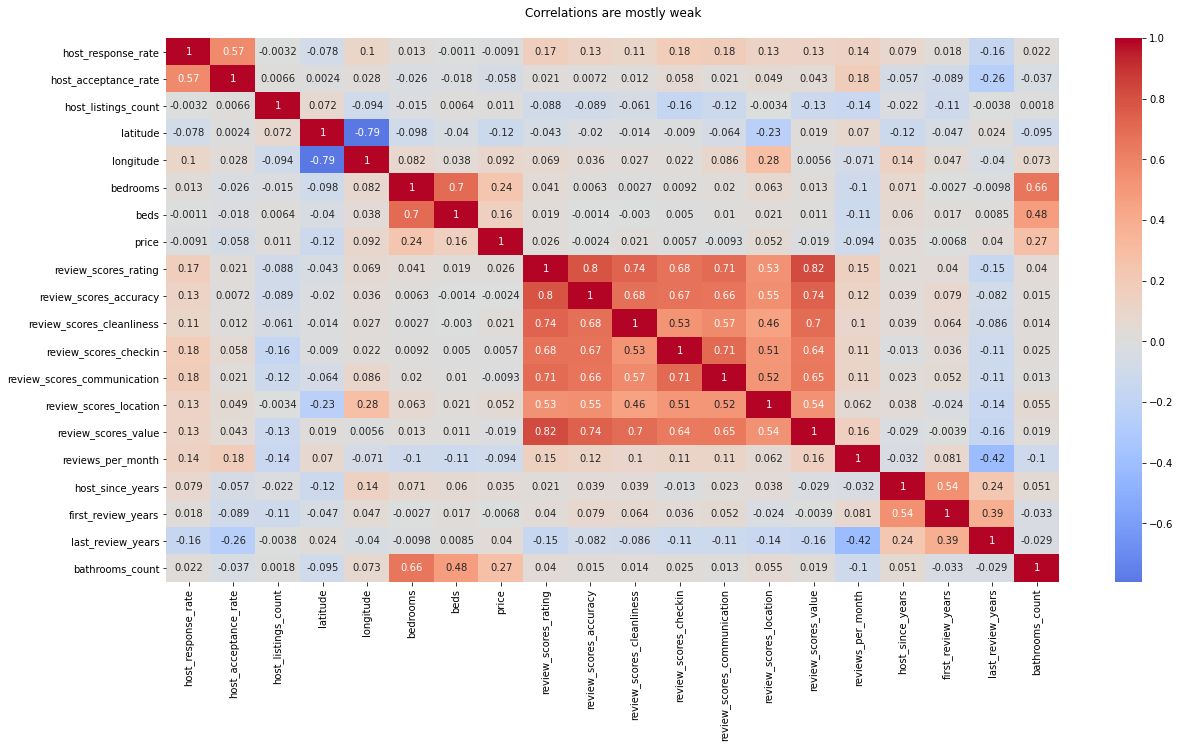

In [51]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(listings[listings.describe(exclude = ['O', 'int64']).T.index].corr(), 
            ax = ax, cmap = 'coolwarm', center = 0, annot = True, fmt = '.2g')
plt.title('Correlations are mostly weak\n')
plt.show()

Check distributions

In [52]:
fig = px.histogram(listings, x = 'price', title = 'Original distribution of prices', 
                   width = 700, height = 400)
fig.show()

In [53]:
ln_y = np.log(listings['price'])

fig = px.histogram(ln_y, title = 'Log scaled distribution of prices', 
                   width = 700, height = 400, nbins = 100, labels = None)
fig.update_layout(showlegend=False)
fig.show()

In [54]:
listings = listings[listings['price'] <= 1000]

In [55]:
fig = px.histogram(listings, x = 'price', title = 'Original distribution of prices', 
                   width = 700, height = 400)
fig.show()

In [56]:
ln_y = np.log(listings['price'])

fig = px.histogram(ln_y, title = 'Log scaled distribution of prices', 
                   width = 700, height = 400, nbins = 50, labels = None)
fig.update_layout(showlegend=False)
fig.show()

Check distribution of continuous numeric features. After looking at extreme values, cut off their ranges

In [57]:
listings = listings[listings['host_listings_count'] <= 150]
listings = listings[listings['minimum_nights'] <= 10]
listings = listings[listings['reviews_per_month'] <= 7]
listings = listings[listings['last_review_years'] <= 6]

listings = listings[listings['bathrooms_count'] >= 1]

The following numerical features should be binned to groups
- bedrooms
- bathrooms

In [58]:
listings['bedrooms'] = listings['bedrooms'].apply(lambda x: '1_bedroom' if x == 1 else ('2_bedrooms' if x == 2 else '2_plus_bedrooms'))
listings['bathrooms_count'] = listings['bathrooms_count'].apply(lambda x: '1_bathroom' if x == 1 else ('1.5_bathrooms' if x == 1.5 else ('2_bathrooms' if x == 2 else '2_plus_bathrooms')))

In [59]:
numericals = listings.select_dtypes(exclude = ['O', 'int64']).columns.tolist()
numericals.remove('latitude')
numericals.remove('longitude')
numericals.remove('price')

for i in numericals:
    
    fig = px.histogram(listings, x = i, title = 'Distribution of ' + i, 
                   width = 500, height = 350)
    fig.show()

Beds bs Bedrooms

Keeping the bed count may be helpful - it differentiates between listings with the same bedroom count, but with different amounts of beds

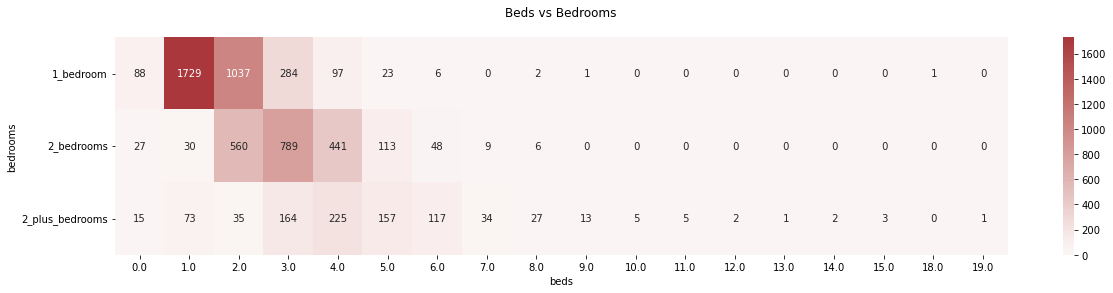

In [60]:
fig, ax = plt.subplots(figsize = (20, 4))
sns.heatmap(listings.pivot_table(index = 'bedrooms', columns = 'beds', values = 'id', aggfunc = 'count').fillna(0), 
            ax = ax, cmap = 'vlag', center = 0, annot = True, fmt = '2g')
plt.title('Beds vs Bedrooms\n')
plt.yticks(va = 'center', rotation = 0)
plt.show()

#### Check int features

In [61]:
listings.describe(include = 'int64', 
                  percentiles = [.1, .25, .5, .75, .9, .99]).T

count          mean           std     min  \
id                               6182.0  2.237235e+07  1.405812e+07  6623.0   
host_is_superhost                6182.0  4.077968e-01  4.914648e-01     0.0   
host_has_profile_pic             6182.0  9.977354e-01  4.753816e-02     0.0   
host_identity_verified           6182.0  8.702685e-01  3.360350e-01     0.0   
accommodates                     6182.0  3.947104e+00  1.955239e+00     1.0   
minimum_nights                   6182.0  2.048366e+00  1.017445e+00     1.0   
has_availability                 6182.0  9.966030e-01  5.818907e-02     0.0   
availability_30                  6182.0  9.459884e+00  9.148309e+00     0.0   
availability_60                  6182.0  2.565076e+01  1.902862e+01     0.0   
availability_90                  6182.0  4.507587e+01  2.940118e+01     0.0   
availability_365                 6182.0  2.104021e+02  1.268637e+02     0.0   
number_of_reviews                6182.0  6.886752e+01  8.779065e+01     1.0   
number_of_reviews_ltm            6182.0  5.710935e+00  9.431386e+00     0.0   
number_of_reviews_l30d           6182.0  1.215950e+00  2.010839e+00     0.0   
instant_bookable                 6182.0  6.908767e-01  4.621695e-01     0.0   
description_host                 6182.0  3.984148e-01  4.896113e-01     0.0   
description_neighbourhood        6182.0  2.919767e-01  4.547084e-01     0.0   
bathrooms_shared                 6182.0  7.554190e-02  2.642851e-01     0.0   
amenity_tv                       6182.0  8.296668e-01  3.759557e-01     0.0   
amenity_air_conditioning         6182.0  8.319314e-01  3.739574e-01     0.0   
amenity_washer                   6182.0  7.025235e-01  4.571849e-01     0.0   
amenity_hair_dryer               6182.0  9.560013e-01  2.051088e-01     0.0   
amenity_workspace                6182.0  6.782595e-01  4.671818e-01     0.0   
amenity_heating                  6182.0  9.820446e-01  1.327999e-01     0.0   
amenity_essentials               6182.0  9.616629e-01  1.920243e-01     0.0   
amenity_hot_water                6182.0  8.240052e-01  3.808466e-01     0.0   
amenity_iron                     6182.0  7.298609e-01  4.440674e-01     0.0   
amenity_self_check-in            6182.0  4.852798e-03  6.949842e-02     0.0   
amenity_long_term_stays_allowed  6182.0  8.893562e-01  3.137159e-01     0.0   
amenity_shampoo                  6182.0  7.065675e-01  4.553717e-01     0.0   
amenity_kitchen                  6182.0  8.384018e-01  3.681116e-01     0.0   
amenity_wifi                     6182.0  9.592365e-01  1.977579e-01     0.0   
amenity_pets_allowed             6182.0  1.779359e-03  4.214832e-02     0.0   
amenity_hangers                  6182.0  8.731802e-01  3.327979e-01     0.0   
amenity_refrigerator             6182.0  7.230670e-01  4.475193e-01     0.0   
name_length                      6182.0  5.269977e+00  2.110919e+00     0.0   
description_length               6182.0  1.272878e+02  4.370208e+01     0.0   
name_touristy                    6182.0  2.009059e-01  4.007102e-01     0.0   

                                       10%          25%         50%  \
id                               3139008.4  10899759.75  21950985.5   
host_is_superhost                      0.0         0.00         0.0   
host_has_profile_pic                   1.0         1.00         1.0   
host_identity_verified                 0.0         1.00         1.0   
accommodates                           2.0         2.00         4.0   
minimum_nights                         1.0         1.00         2.0   
has_availability                       1.0         1.00         1.0   
availability_30                        0.0         1.00         7.0   
availability_60                        0.0         7.00        26.0   
availability_90                        0.0        20.00        51.0   
availability_365                       0.0        97.00       244.0   
number_of_reviews                      2.0         8.00        34.0   
number_of_reviews_ltm        

In [62]:
listings['accommodates'] = listings['accommodates'].apply(lambda x: '1' if x == 1 else ('2' if x == 2 else ('3' if x == 3 else ('4' if x == 4 else ('5' if x == 5 else '5_plus')))))

In [63]:
listings = listings[listings['number_of_reviews'] <= 400]

Check balances of 1/0 (true/false) features. Drop features with overwhelming majorities

In [64]:
true_false_features = listings.select_dtypes('int64').max()[listings.select_dtypes('int64').max() == 1].index.tolist()
print(true_false_features)

['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable', 'description_host', 'description_neighbourhood', 'bathrooms_shared', 'amenity_tv', 'amenity_air_conditioning', 'amenity_washer', 'amenity_hair_dryer', 'amenity_workspace', 'amenity_heating', 'amenity_essentials', 'amenity_hot_water', 'amenity_iron', 'amenity_self_check-in', 'amenity_long_term_stays_allowed', 'amenity_shampoo', 'amenity_kitchen', 'amenity_wifi', 'amenity_pets_allowed', 'amenity_hangers', 'amenity_refrigerator', 'name_touristy']


In [65]:
listings[true_false_features].describe(percentiles = [.01, .1, .25, .5, .75, .9, .99]).T.drop(['mean', 'std'], 1).astype(int)

count  min  1%  10%  25%  50%  75%  90%  99%  \
host_is_superhost                 6125    0   0    0    0    0    1    1    1   
host_has_profile_pic              6125    0   1    1    1    1    1    1    1   
host_identity_verified            6125    0   0    0    1    1    1    1    1   
has_availability                  6125    0   1    1    1    1    1    1    1   
instant_bookable                  6125    0   0    0    0    1    1    1    1   
description_host                  6125    0   0    0    0    0    1    1    1   
description_neighbourhood         6125    0   0    0    0    0    1    1    1   
bathrooms_shared                  6125    0   0    0    0    0    0    0    1   
amenity_tv                        6125    0   0    0    1    1    1    1    1   
amenity_air_conditioning          6125    0   0    0    1    1    1    1    1   
amenity_washer                    6125    0   0    0    0    1    1    1    1   
amenity_hair_dryer                6125    0   0    1    1    1    1    1    1   
amenity_workspace                 6125    0   0    0    0    1    1    1    1   
amenity_heating                   6125    0   0    1    1    1    1    1    1   
amenity_essentials                6125    0   0    1    1    1    1    1    1   
amenity_hot_water                 6125    0   0    0    1    1    1    1    1   
amenity_iron                      6125    0   0    0    0    1    1    1    1   
amenity_self_check-in             6125    0   0    0    0    0    0    0    0   
amenity_long_term_stays_allowed   6125    0   0    0    1    1    1    1    1   
amenity_shampoo                   6125    0   0    0    0    1    1    1    1   
amenity_kitchen                   6125    0   0    0    1    1    1    1    1   
amenity_wifi                      6125    0   0    1    1    1    1    1    1   
amenity_pets_allowed              6125    0   0    0    0    0    0    0    0   
amenity_hangers                   6125    0   0    0    1    1    1    1    1   
amenity_refrigerator              6125    0   0    0    0    1    1    1    1   
name_touristy                     6125    0   0    0    0    0    0    1    1   

                                 max  
host_is_superhost                  1  
host_has_profile_pic               1  
host_identity_verified             1  
has_availability                   1  
instant_bookable                   1  
description_host                   1  
description_neighbourhood          1  
bathrooms_shared                   1  
amenity_tv                         1  
amenity_air_conditioning           1  
amenity_washer                     1  
amenity_hair_dryer                 1  
amenity_workspace                  1  
amenity_heating                    1  
amenity_essentials                 1  
amenity_hot_water                  1  
amenity_iron                       1  
amenity_self_check-in              1  
amenity_long_term_stays_allowed    1  
amenity_shampoo                    1  
amenity_kitchen                    1  
amenity_wifi                       1  
amenity_pets_allowed               1  
amenity_hangers                    1  
amenity_refrigerator               1  
name_touristy                      1

In [66]:
L = listings.shape[0]

for i in true_false_features:
    
    n_true = listings[i].sum()
    n_false = L - n_true
    
    fig = px.bar(x = [0, 1], y = [n_false, n_true], labels = {'x' : i, 'y' : ''},
                 title = 'Value counts of ' + i, width = 500, height = 350)
    fig.update_traces(width = 1/3)
    fig.update_xaxes(type = 'category')
    fig.show()

In [67]:
listings.drop(['host_has_profile_pic', 'has_availability', 'amenity_heating', 'availability_60',
               'amenity_pets_allowed', 'amenity_self_check-in'], 1, inplace = True) 

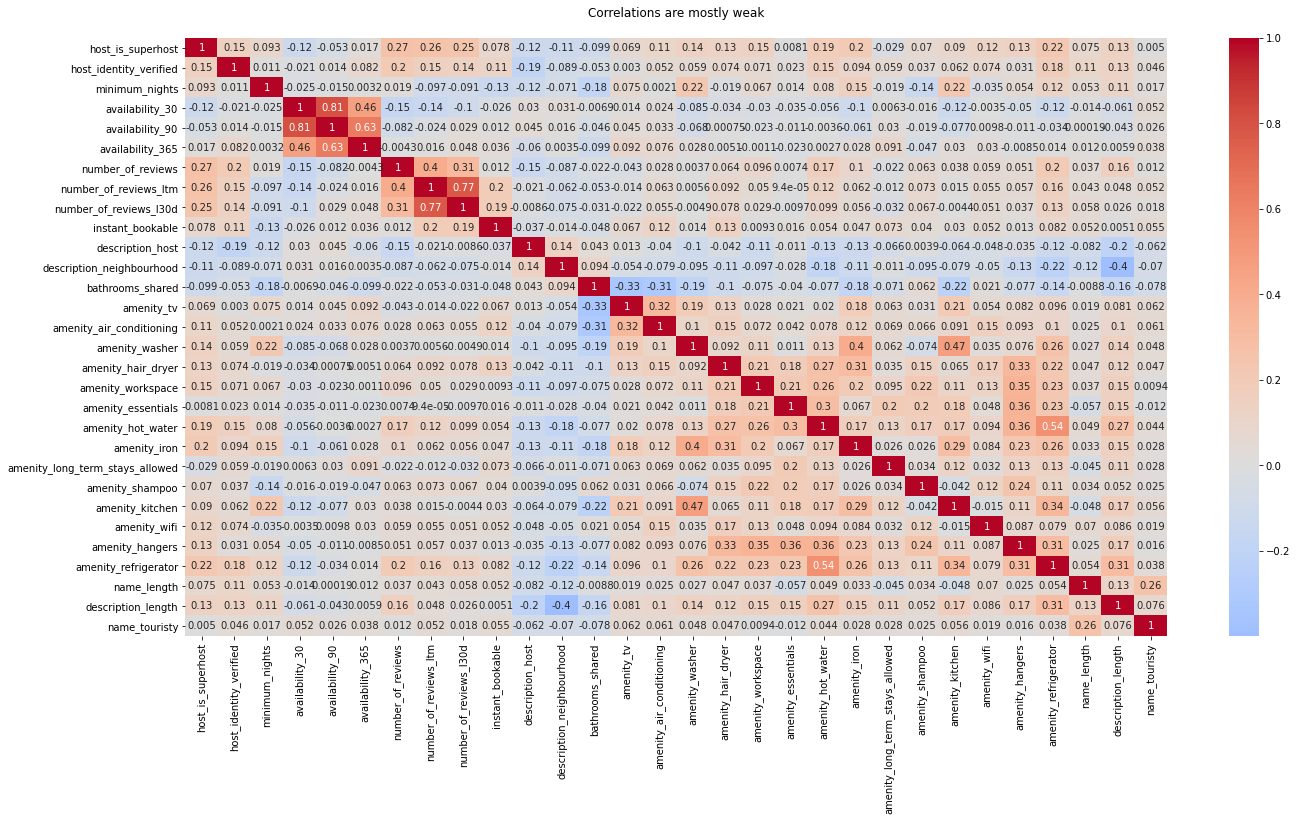

In [68]:
fig, ax = plt.subplots(figsize = (22, 11))
sns.heatmap(listings[listings.drop('id', 1).select_dtypes(include = 'int64').columns].corr(), 
            ax = ax, cmap = 'coolwarm', center = 0, annot = True, fmt = '.2g')
plt.title('Correlations are mostly weak\n')
plt.show()

### Main cleaning is now complete: final overview of listing dataset

In [69]:
listings.dtypes.value_counts()

int64      31
float64    18
object      8
dtype: int64

In [70]:
listings = listings[listings['review_scores_value'].notnull()]
listings = listings[listings['beds'].notnull()]

In [71]:
listings.isnull().sum()[listings.isnull().sum() > 0]

host_response_time      1056
host_response_rate      1056
host_acceptance_rate    1045
dtype: int64

Changes to be made after data analysis (next notebook):
- drop
    - 'neighbourhood_group_cleansed'
    - longitude
    - latitude
    
- treat
    - NaNs for host_response_time, rate and acceptance rate features. GBMs can take care of it, linreg needs manual adj

### Reviews

In [116]:
# reviews[(reviews['reviewer_name'] == 'Kristof')] # &
# #         (reviews['listing_id'] == 19493233)]['comments'][328156]

Reviews data for now will not be used. Listings data has ratings, comment counts and other feedback related info

### Save cleaned file for further analysis

In [73]:
listings.to_csv('data/listings_cleaned.csv', index = False)